In [20]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from sklearn.feature_selection import RFE

In [25]:
file_path = 'Datasets/rabbit_balanced_2.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Irritation
0,0.717468,0.717468,0.121427,0.521486,0.100715,0.900222,0.963654,0.929143,0.963799,0.959184,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0
1,0.883389,0.883389,0.010083,0.598491,0.536107,0.263989,0.454747,0.434600,0.454230,0.433673,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0
2,0.802780,0.802780,0.014911,0.591845,0.725800,0.299562,0.323755,0.310550,0.323723,0.321429,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,1
3,0.618649,0.618649,0.016091,0.629816,0.755228,0.442073,0.193338,0.173261,0.193305,0.214286,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,1
4,0.371470,0.371470,0.022782,0.658641,0.583083,0.174216,0.246708,0.236648,0.246665,0.244898,...,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0


In [26]:
df.shape

(703, 196)

In [27]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation']) 
y = df['Irritation']

In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (562, 195)
Shape of X_test: (141, 195)
Shape of y_train: (562,)
Shape of y_test: (141,)


## Correlation + Variation

In [31]:
def feature_selection(df):
    nonzero_thrd=0.01
    cor_thrd=0.9
    print(f"Original shape of data: {df.shape}")
   
    #Remove features with low variance
    nonzero_df = df.loc[:, df.var() > nonzero_thrd]
    print(f"Removed {df.shape[1] - nonzero_df.shape[1]} features with variance <= {nonzero_thrd}")
    
    #Remove highly correlated features
    corr_matrix = nonzero_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_thrd)]
    print(f"Removed {len(to_drop)} highly correlated features with correlation > {cor_thrd}")
    
    #Return the cleaned dataset
    cleaned_df = nonzero_df.drop(to_drop, axis=1)
    print(f"Final shape of data: {cleaned_df.shape}")
    return cleaned_df


df_cleaned = feature_selection(df)
df = feature_selection(df)
CorrVar_selected_features = list(df_cleaned.columns)

Original shape of data: (703, 39)
Removed 0 features with variance <= 0.01
Removed 0 highly correlated features with correlation > 0.9
Final shape of data: (703, 39)
Original shape of data: (703, 39)
Removed 0 features with variance <= 0.01
Removed 0 highly correlated features with correlation > 0.9
Final shape of data: (703, 39)


In [32]:
# Convert to DataFrame
df_selected = df[CorrVar_selected_features]

# Export to Excel
df_selected.to_excel("Features/rabbit_b_corrvar.xlsx", index=False)

## Lasso

In [33]:
# Train a Lasso model
lasso = Lasso(alpha=0.005)
lasso.fit(X, y)

# Get important features (non-zero coefficients)
important_features = X.columns[np.abs(lasso.coef_) > 0]
print("Selected Features:", important_features)



Selected Features: Index(['MaxEStateIndex', 'HeavyAtomMolWt', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'AvgIpc', 'Chi1v', 'SMR_VSA3', 'SMR_VSA6',
       'EState_VSA2', 'FractionCSP3', 'HeavyAtomCount',
       'NumAromaticCarbocycles', 'NumHeteroatoms', 'fr_NH1', 'fr_aldehyde',
       'fr_benzene'],
      dtype='object')


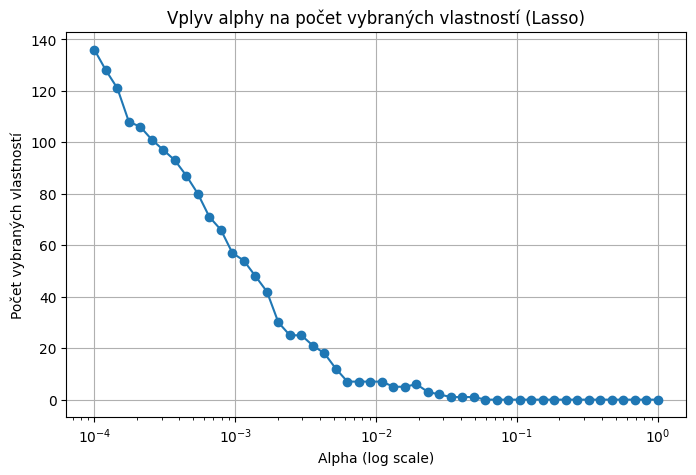

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

#alpha values for testing
alphas = np.logspace(-4, 0, 50) 

selected_features_counts = []

#for every alpha value train lasso model
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    important_features = X.columns[np.abs(lasso.coef_) > 0]
    selected_features_counts.append(len(important_features)) 

    
#Ploting how aloha values changes accuracy 
plt.figure(figsize=(8, 5))
plt.plot(alphas, selected_features_counts, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Počet vybraných vlastností')
plt.title('Vplyv alphy na počet vybraných vlastností (Lasso)')
plt.grid(True)
plt.show()


In [36]:
#testing alpha values 
alphas = np.logspace(-4, 0, 50)

# Save number of selected features and results for every model 
selected_features_counts = {  'XGBoost': [], 'DecisionTree': [], 'RandomForest': [], 'SVM': [], 'KNN': [] }
accuracies = {  'XGBoost': [], 'DecisionTree': [], 'RandomForest': [], 'SVM': [], 'KNN': [] }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Try every alpha value 
for alpha in alphas:
    # Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    # get important features 
    important_features = X.columns[np.abs(lasso.coef_) > 0]
    
    # Test if the features exist in X train and test
    X_train_lasso = X_train[important_features]
    X_test_lasso = X_test[important_features] 

    if X_train_lasso.shape[1] == 0:
        #print at the end, when there are no more features to select 
        print("No important features selected. Consider adjusting alpha.")
        break

    
    # XGBoost model
    xgb = XGBClassifier(objective='binary:logistic')
    xgb.fit(X_train_lasso, y_train)
    y_pred_xgb = xgb.predict(X_test_lasso)
    accuracies['XGBoost'].append(accuracy_score(y_test, y_pred_xgb))
    selected_features_counts['XGBoost'].append(len(important_features))
    
    # Decision Tree model
    tree = DecisionTreeClassifier()
    tree.fit(X_train_lasso, y_train)
    y_pred_tree = tree.predict(X_test_lasso)
    accuracies['DecisionTree'].append(accuracy_score(y_test, y_pred_tree))
    selected_features_counts['DecisionTree'].append(len(important_features))
    
    # Random Forest model
    rf = RandomForestClassifier()
    rf.fit(X_train_lasso, y_train)
    y_pred_rf = rf.predict(X_test_lasso)
    accuracies['RandomForest'].append(accuracy_score(y_test, y_pred_rf))
    selected_features_counts['RandomForest'].append(len(important_features))
    
    # SVM model
    svm = SVC()
    svm.fit(X_train_lasso, y_train)
    y_pred_svm = svm.predict(X_test_lasso)
    accuracies['SVM'].append(accuracy_score(y_test, y_pred_svm))
    selected_features_counts['SVM'].append(len(important_features))
    
    # KNN model
    knn = KNeighborsClassifier()
    knn.fit(X_train_lasso, y_train)
    y_pred_knn = knn.predict(X_test_lasso)
    accuracies['KNN'].append(accuracy_score(y_test, y_pred_knn))
    selected_features_counts['KNN'].append(len(important_features))


No important features selected. Consider adjusting alpha.


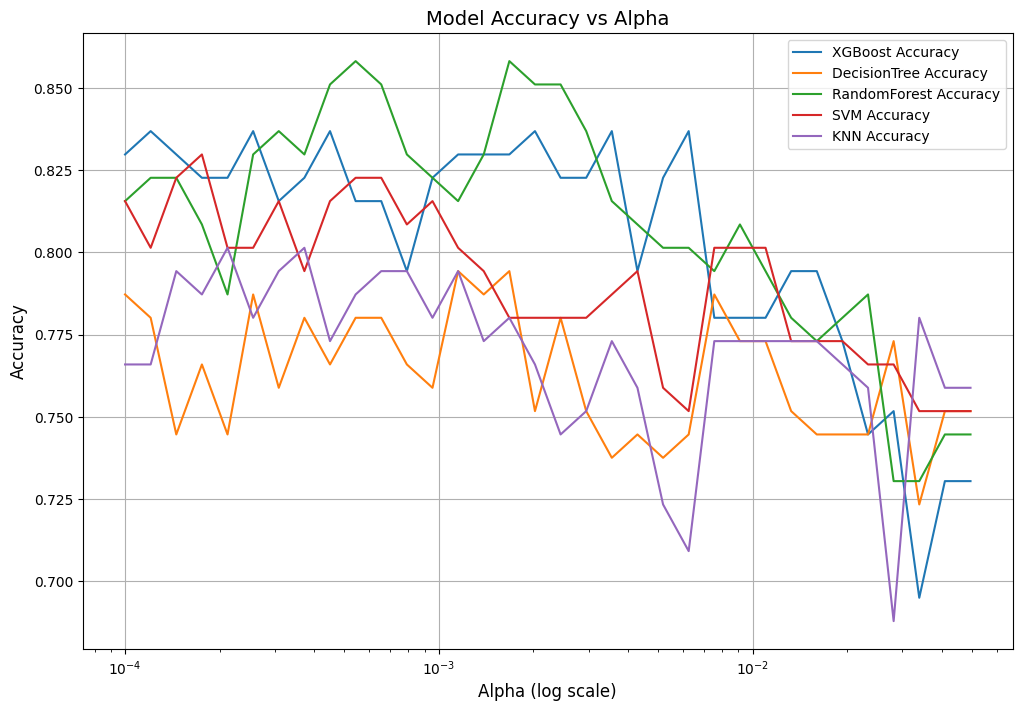

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for model in selected_features_counts:
    valid_alphas = []
    valid_accuracies = []
    
    for i, alpha in enumerate(alphas):
        if i < len(accuracies[model]) and accuracies[model][i] is not None:
            valid_alphas.append(alpha)
            valid_accuracies.append(accuracies[model][i])
    
    # plot accuracy for every model 
    plt.plot(valid_alphas, valid_accuracies, label=f'{model} Accuracy')


plt.xscale('log')

#axis 
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy vs Alpha', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [41]:
feature_names_Lasso = list(important_features.values)

In [44]:
selected_features = feature_names_Lasso
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/Rabbit_LAsso2.xlsx", index=False)

## Models

In [46]:
def xgboost(X_train, y_train, X_test, y_test):
    # Instantiate the XGBoost classifier
    xgb_model = XGBClassifier(objective='binary:logistic')

    # Perform cross-validation with 5 folds and accuracy scoring
    cv_results = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

    # Print cross-validation results
    print("Cross-validation results:")
    print(cv_results)
    print("Average Accuracy:", cv_results.mean())

    # Fit the model on the entire training dataset
    xgb_model.fit(X_train, y_train)

    # Evaluate accuracy on test data
    test_accuracy = xgb_model.score(X_test, y_test)
    train_accuracy = xgb_model.score(X_train, y_train)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    y_pred_test = xgb_model.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    return xgb_model

In [47]:
def random_forest(X_train, y_train, X_test, y_test):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier()

    # Cross-validation
    cv_results = cross_val_score(rf, X_train, y_train, cv=5)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")


    y_pred_test = rf.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return rf

In [48]:
def decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier()
    
    # Cross-validation
    cv_results = cross_val_score(dt, X_train, y_train, cv = 5)
    dt.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    y_pred_test = dt.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return dt
    

In [49]:
def k_neigbhors(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier()

    cv_results = cross_val_score(knn, X_train, y_train, cv=5)
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    y_pred_test = knn.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return knn

In [50]:
def Support_vector_machine(X_train, y_train, X_test, y_test):
    svm= SVC(probability=True, kernel="linear", C=1)

    cv_results = cross_val_score(svm, X_train, y_train, cv=5)
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = svm.predict(X_test)
    y_pred_train = svm.predict(X_train)

    # Calculate accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Print the results
    print("Cross-validation results:", cv_results)
    print(f"Average Accuracy: {np.mean(cv_results)}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")


    y_pred_test = svm.predict(X_test)
    # Precision, Recall, F1-score (binary classification)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return svm

In [51]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (562, 195)
Shape of X_test: (141, 195)
Shape of y_train: (562,)
Shape of y_test: (141,)


In [52]:
print("XGBoost:")
xgb_model = xgboost(X_train, y_train, X_test, y_test)
print("\nRandom forest:")
rf_model = random_forest(X_train, y_train, X_test, y_test)
print("\nDecision tree:")
dt_model = decision_tree(X_train, y_train, X_test, y_test)
print("\nKNN:")
knn_model = k_neigbhors(X_train, y_train, X_test, y_test)
print("\nSVM")
svm_model = Support_vector_machine(X_train, y_train, X_test, y_test)

XGBoost:
Cross-validation results:
[0.75221239 0.84955752 0.80357143 0.80357143 0.8125    ]
Average Accuracy: 0.8042825537294565
Train Accuracy: 1.0
Test Accuracy: 0.8156028368794326
Precision: 0.8169014084507042
Recall: 0.8169014084507042
F1 Score: 0.8169014084507042

Random forest:
Cross-validation results: [0.79646018 0.84070796 0.8125     0.8125     0.84821429]
Average Accuracy: 0.8220764854614412
Train Accuracy: 1.0
Test Accuracy: 0.8652482269503546
Precision: 0.8513513513513513
Recall: 0.8873239436619719
F1 Score: 0.8689655172413793

Decision tree:
Cross-validation results: [0.71681416 0.77876106 0.72321429 0.70535714 0.74107143]
Average Accuracy: 0.7330436156763589
Train Accuracy: 1.0
Test Accuracy: 0.7801418439716312
Precision: 0.7777777777777778
Recall: 0.7887323943661971
F1 Score: 0.7832167832167832

KNN:
Cross-validation results: [0.76106195 0.74336283 0.75       0.75       0.74107143]
Average Accuracy: 0.7490992414664982
Train Accuracy: 0.8220640569395018
Test Accuracy: 0.7

## SHAP Feature Selection

In [53]:
def xgboost_sort_features(model, X_train):
     # Create SHAP explainer and calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_train)

    # Calculate feature importance (mean absolute SHAP values)
    feature_importance = np.abs(shap_values).mean(0)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order of importance
    return sorted_idx

In [54]:
def tree_sort_features(model, X_train):       
    #  Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)  # Shape: (samples, features, 2)

    # Compute SHAP difference (Class 1 - Class 0) and take mean absolute values
    shap_values_diff = shap_values[:, :, 1] - shap_values[:, :, 0]
    feature_importance = np.abs(shap_values_diff).mean(axis=0)  # Shape: (features,)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    return sorted_idx

In [55]:
def kernel_sort_features(model, X_train):
    # Use smaller sample for background
    background = X_train.sample(20)
    explainer = shap.KernelExplainer(model.predict, background)
    
    # Compute SHAP on a sample, limit nsamples
    X_sample = X_train.sample(100)
    shap_values = explainer.shap_values(X_sample, nsamples=100)
    
    shap_values = np.array(shap_values)
    feature_importance = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(feature_importance)[::-1]
    return sorted_idx


In [56]:
SHAP_Feature_selection = []

In [60]:
def find_best_num_features(X_train, y_train, X_test, y_test, model, max_features=100):
    sorted_idx = xgboost_sort_features(model, X_train)
    #sorted_idx = tree_sort_features(model, X_train)
    #sorted_idx = kernel_sort_features(model, X_train)
    
    validation_accuracies = []
    train_accuracies = []

    for num_features in range(1, max_features + 1):
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # Clone the model to prevent modifying the original instance
        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)
        y_pred_train = model_copy.predict(X_train_selected)
        accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        validation_accuracies.append(accuracy)
        train_accuracies.append(train_accuracy)

    plt.plot(range(1, max_features + 1), validation_accuracies, marker='o')
    #plt.plot(range(1, max_features + 1), train_accuracies, marker='o', color = "red")
    plt.xlabel("Number of Features")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Features")
    plt.show()

    optimal_num_features = np.argmax(validation_accuracies) + 1
    print(f"Optimal number of features: {optimal_num_features}")

    selected_features = X_train.columns[sorted_idx[:optimal_num_features]]
    X_train_optimal = X_train[selected_features]
    X_test_optimal = X_test[selected_features]

    return X_train_optimal, X_test_optimal

In [58]:
def full_feature_analysis(X_train, y_train, X_test, y_test, model, max_features=100):
    #sorted_idx = xgboost_sort_features(model, X_train)
    #sorted_idx = tree_sort_features(model, X_train)
    sorted_idx = kernel_sort_features(model, X_train)

    validation_accuracies = []
    validation_precisions = []
    validation_recalls = []

    feature_counts = list(range(1, max_features + 1))

    for num_features in feature_counts:
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_pred = model_copy.predict(X_test_selected)

        validation_accuracies.append(accuracy_score(y_test, y_pred))
        validation_precisions.append(precision_score(y_test, y_pred))
        validation_recalls.append(recall_score(y_test, y_pred))

    #Plot 1: Accuracy, Precision, and Recall
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, validation_accuracies, label='Presnosť', marker='o')
    plt.plot(feature_counts, validation_precisions, label='Precíznosť', marker='x')
    plt.plot(feature_counts, validation_recalls, label='Citlivosť', marker='s')
    plt.xlabel('Počet deskriptorov')
    plt.ylabel('Skóre')
    plt.title('Metriky pri rôznych počtoch deskriptorov')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Plot 2 ROC Curves for selected feature counts
    selected_feature_counts = [10, 20, 50, 75, 100]
    plt.figure(figsize=(10, 8))

    for num_features in selected_feature_counts:
        selected_features = X_train.columns[sorted_idx[:num_features]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        model_copy = clone(model)
        model_copy.fit(X_train_selected, y_train)

        y_proba = model_copy.predict_proba(X_test_selected)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{num_features} deskriptory (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Náhodný tip')
    plt.xlabel('Miera falošne pozitívnych')
    plt.ylabel('Miera skutočne pozitívnych')
    plt.title('ROC krivky pre rôzne počty deskriptorov')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Cross-validation results:
[0.77876106 0.7699115  0.8125     0.86607143 0.8125    ]
Average Accuracy: 0.8079487989886219
Train Accuracy: 0.998220640569395
Test Accuracy: 0.7872340425531915
Precision: 0.7808219178082192
Recall: 0.8028169014084507
F1 Score: 0.7916666666666666


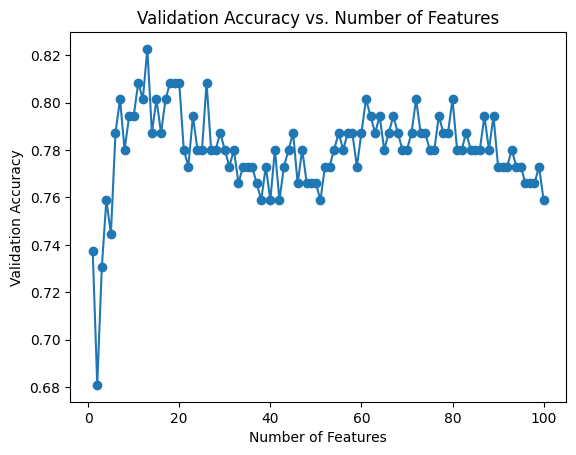

Optimal number of features: 13


In [61]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
xgb_model = xgboost(X_train, y_train, X_test, y_test)

X_train_selected, X_test_selected = find_best_num_features(X_train, y_train, X_test, y_test, xgb_model)

1
Cross-validation results:
[0.84070796 0.82300885 0.79464286 0.8125     0.79464286]
Average Accuracy: 0.8131005056890013
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8085106382978723
Precision: 0.8142857142857143
Recall: 0.8028169014084507
F1 Score: 0.8085106382978723


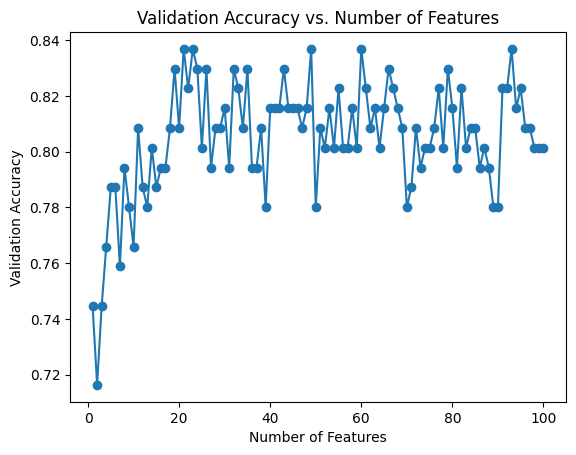

Optimal number of features: 21
2
Cross-validation results:
[0.77876106 0.78761062 0.80357143 0.72321429 0.84821429]
Average Accuracy: 0.7882743362831859
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8652482269503546
Precision: 0.8170731707317073
Recall: 0.9436619718309859
F1 Score: 0.8758169934640523


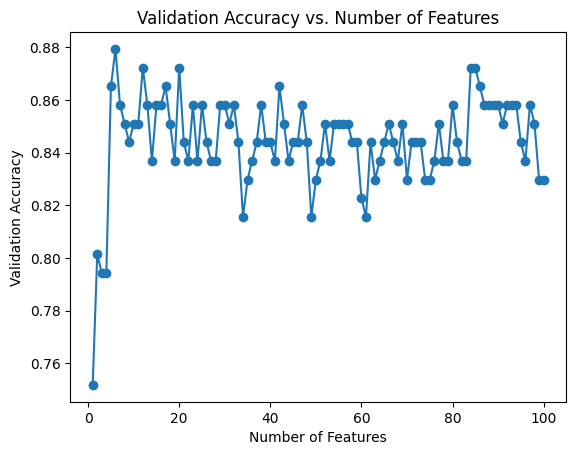

Optimal number of features: 6
3
Cross-validation results:
[0.84955752 0.74336283 0.76785714 0.77678571 0.8125    ]
Average Accuracy: 0.7900126422250316
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8439716312056738
Precision: 0.8181818181818182
Recall: 0.8873239436619719
F1 Score: 0.8513513513513513


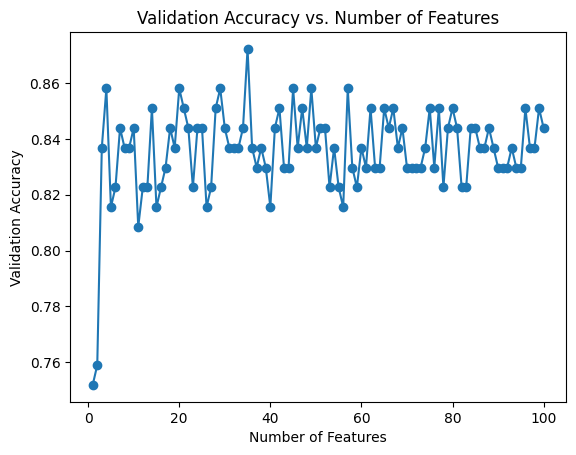

Optimal number of features: 35
4
Cross-validation results:
[0.76106195 0.87610619 0.86607143 0.79464286 0.8125    ]
Average Accuracy: 0.8220764854614412
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8156028368794326
Precision: 0.8461538461538461
Recall: 0.7746478873239436
F1 Score: 0.8088235294117647


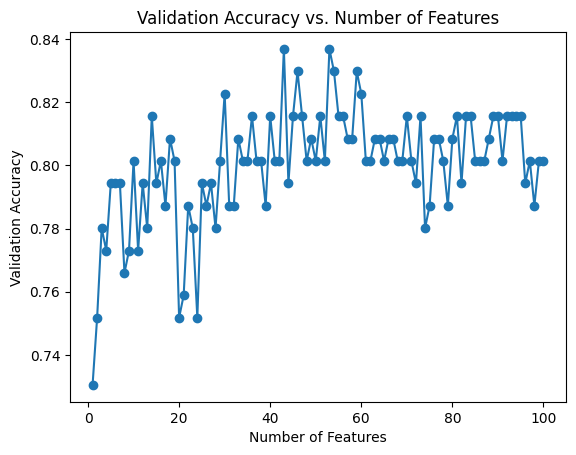

Optimal number of features: 43
5
Cross-validation results:
[0.76106195 0.82300885 0.85714286 0.83928571 0.85714286]
Average Accuracy: 0.8275284450063211
Train Accuracy: 0.998220640569395
Test Accuracy: 0.7446808510638298
Precision: 0.7966101694915254
Recall: 0.6619718309859155
F1 Score: 0.7230769230769231


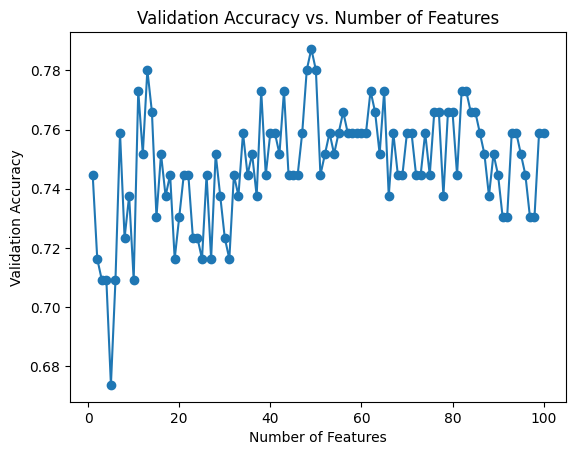

Optimal number of features: 49
6
Cross-validation results:
[0.79646018 0.83185841 0.82142857 0.85714286 0.76785714]
Average Accuracy: 0.8149494310998735
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8156028368794326
Precision: 0.7777777777777778
Recall: 0.8873239436619719
F1 Score: 0.8289473684210527


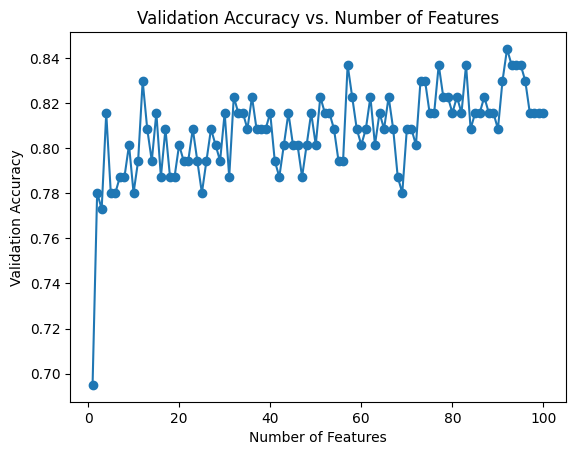

Optimal number of features: 92
7
Cross-validation results:
[0.84070796 0.85840708 0.77678571 0.85714286 0.82142857]
Average Accuracy: 0.8308944374209861
Train Accuracy: 1.0
Test Accuracy: 0.7943262411347518
Precision: 0.7837837837837838
Recall: 0.8169014084507042
F1 Score: 0.8


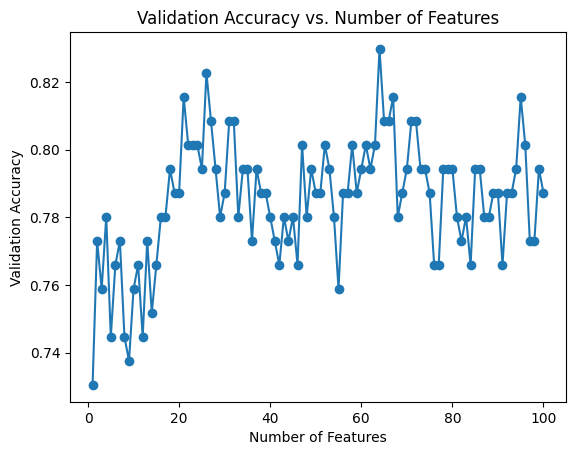

Optimal number of features: 64
8
Cross-validation results:
[0.85840708 0.78761062 0.82142857 0.82142857 0.78571429]
Average Accuracy: 0.8149178255372945
Train Accuracy: 1.0
Test Accuracy: 0.8085106382978723
Precision: 0.782051282051282
Recall: 0.8591549295774648
F1 Score: 0.8187919463087249


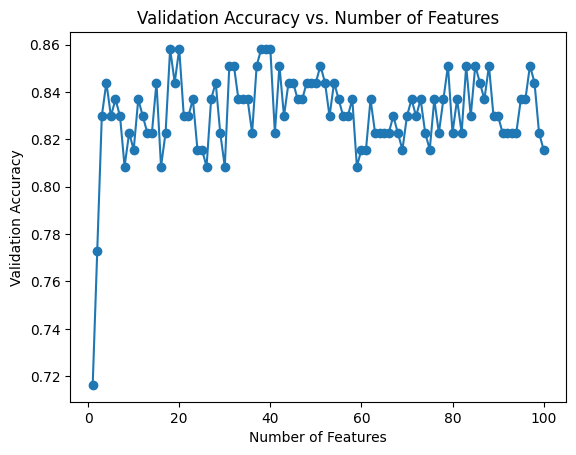

Optimal number of features: 18
9
Cross-validation results:
[0.80530973 0.77876106 0.875      0.8125     0.79464286]
Average Accuracy: 0.8132427307206068
Train Accuracy: 1.0
Test Accuracy: 0.7943262411347518
Precision: 0.7916666666666666
Recall: 0.8028169014084507
F1 Score: 0.7972027972027972


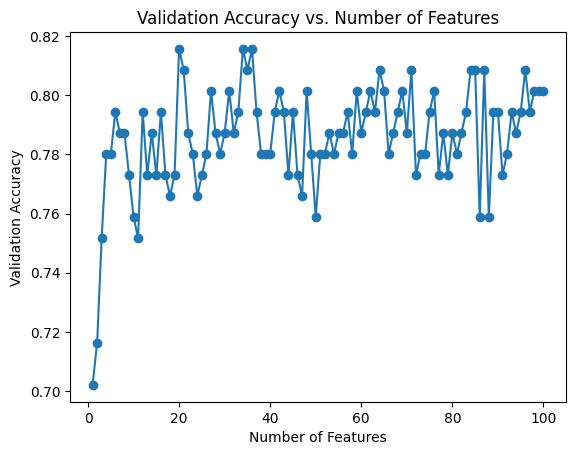

Optimal number of features: 20
10
Cross-validation results:
[0.80530973 0.80530973 0.75       0.82142857 0.85714286]
Average Accuracy: 0.8078381795195954
Train Accuracy: 1.0
Test Accuracy: 0.7659574468085106
Precision: 0.7567567567567568
Recall: 0.7887323943661971
F1 Score: 0.7724137931034483


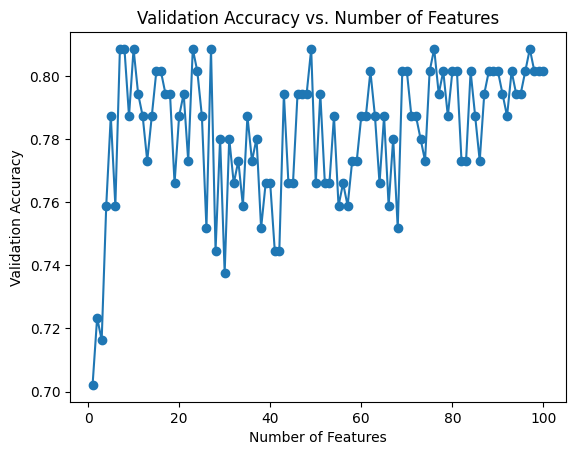

Optimal number of features: 7
11
Cross-validation results:
[0.79646018 0.78761062 0.80357143 0.84821429 0.78571429]
Average Accuracy: 0.8043141592920353
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8226950354609929
Precision: 0.8382352941176471
Recall: 0.8028169014084507
F1 Score: 0.8201438848920863


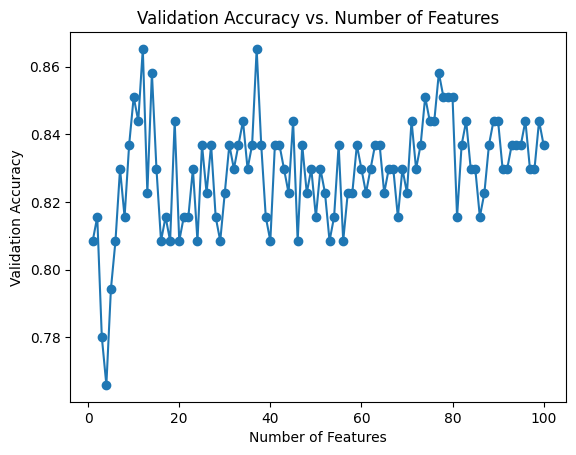

Optimal number of features: 12
12
Cross-validation results:
[0.84070796 0.80530973 0.80357143 0.85714286 0.83928571]
Average Accuracy: 0.8292035398230088
Train Accuracy: 1.0
Test Accuracy: 0.7872340425531915
Precision: 0.7808219178082192
Recall: 0.8028169014084507
F1 Score: 0.7916666666666666


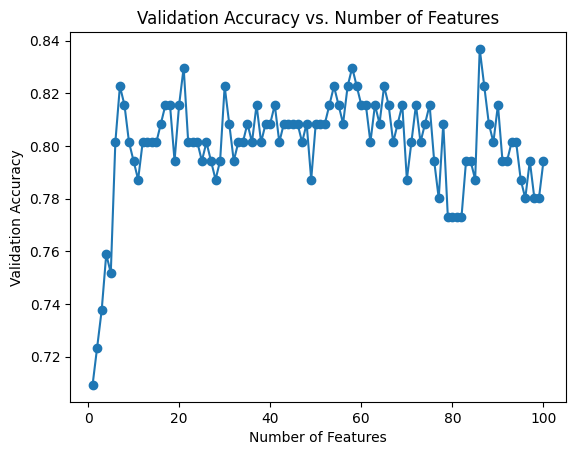

Optimal number of features: 86
13
Cross-validation results:
[0.80530973 0.86725664 0.85714286 0.83035714 0.75      ]
Average Accuracy: 0.8220132743362832
Train Accuracy: 1.0
Test Accuracy: 0.8297872340425532
Precision: 0.821917808219178
Recall: 0.8450704225352113
F1 Score: 0.8333333333333334


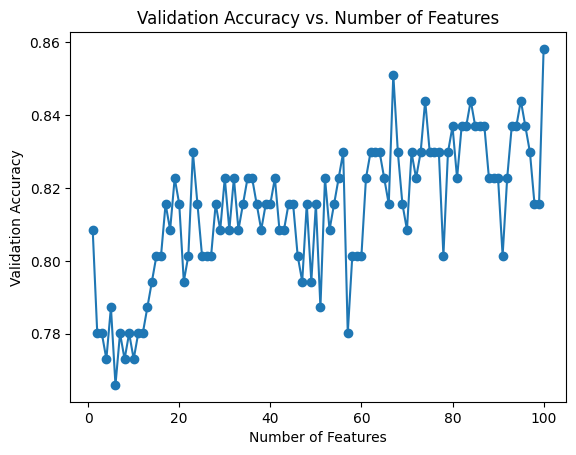

Optimal number of features: 100
14
Cross-validation results:
[0.78761062 0.84070796 0.78571429 0.875      0.85714286]
Average Accuracy: 0.8292351453855877
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8297872340425532
Precision: 0.7764705882352941
Recall: 0.9295774647887324
F1 Score: 0.8461538461538461


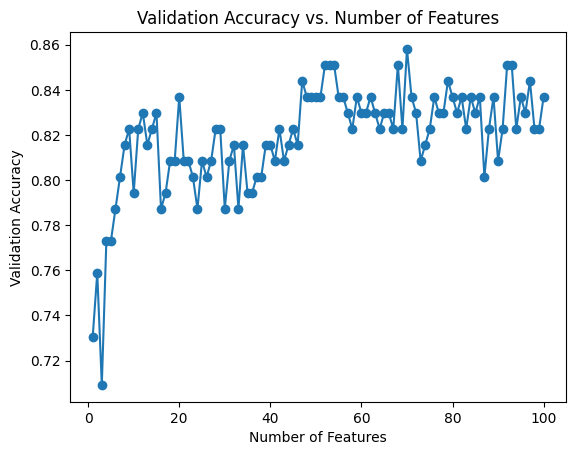

Optimal number of features: 70
15
Cross-validation results:
[0.84070796 0.78761062 0.8125     0.80357143 0.83928571]
Average Accuracy: 0.8167351453855879
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8085106382978723
Precision: 0.8055555555555556
Recall: 0.8169014084507042
F1 Score: 0.8111888111888111


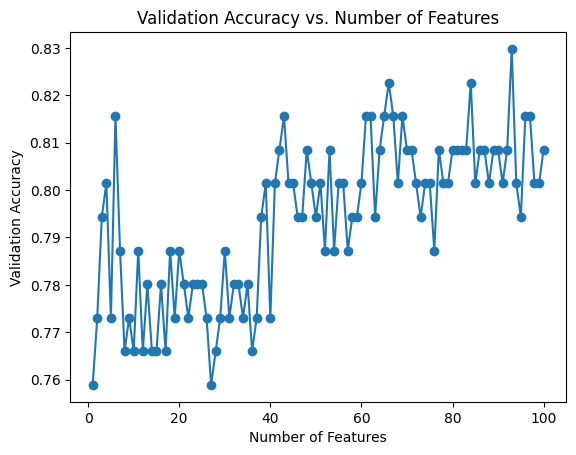

Optimal number of features: 93
16
Cross-validation results:
[0.79646018 0.79646018 0.84821429 0.77678571 0.85714286]
Average Accuracy: 0.8150126422250317
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8439716312056738
Precision: 0.8356164383561644
Recall: 0.8591549295774648
F1 Score: 0.8472222222222222


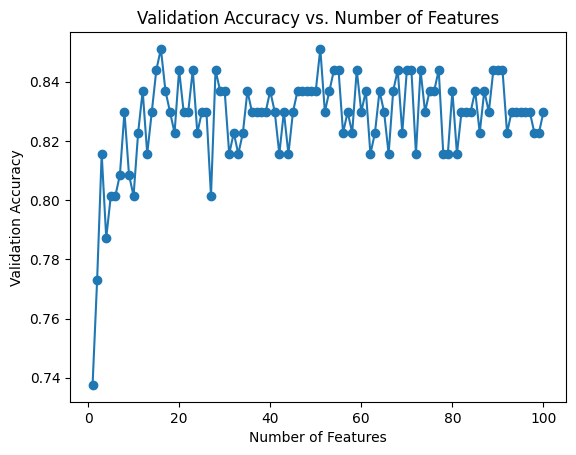

Optimal number of features: 16
17
Cross-validation results:
[0.82300885 0.85840708 0.83035714 0.82142857 0.79464286]
Average Accuracy: 0.8255689001264221
Train Accuracy: 1.0
Test Accuracy: 0.8439716312056738
Precision: 0.8656716417910447
Recall: 0.8169014084507042
F1 Score: 0.8405797101449275


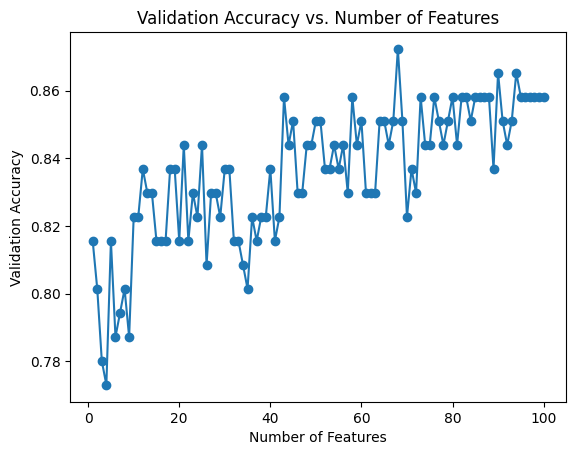

Optimal number of features: 68
18
Cross-validation results:
[0.7699115  0.77876106 0.8125     0.875      0.80357143]
Average Accuracy: 0.8079487989886219
Train Accuracy: 1.0
Test Accuracy: 0.8723404255319149
Precision: 0.8533333333333334
Recall: 0.9014084507042254
F1 Score: 0.8767123287671232


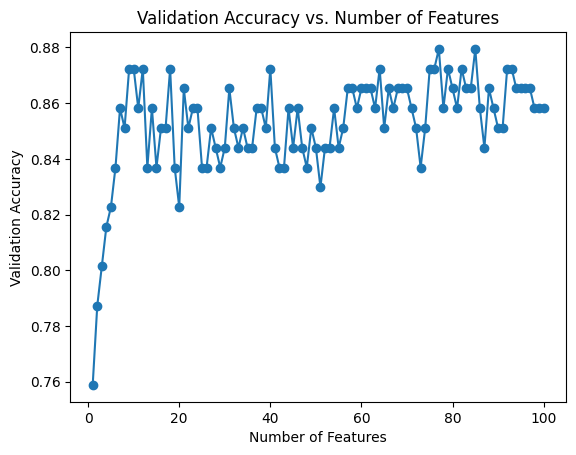

Optimal number of features: 77
19
Cross-validation results:
[0.80530973 0.79646018 0.84821429 0.78571429 0.79464286]
Average Accuracy: 0.8060682680151705
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8156028368794326
Precision: 0.8
Recall: 0.8450704225352113
F1 Score: 0.821917808219178


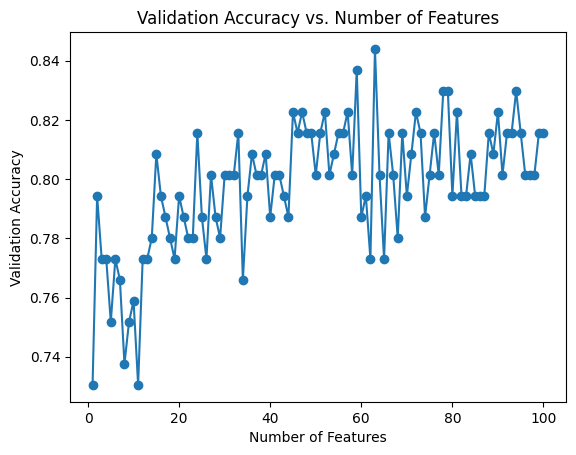

Optimal number of features: 63
20
Cross-validation results:
[0.77876106 0.79646018 0.83035714 0.89285714 0.8125    ]
Average Accuracy: 0.8221871049304678
Train Accuracy: 0.998220640569395
Test Accuracy: 0.8368794326241135
Precision: 0.8076923076923077
Recall: 0.8873239436619719
F1 Score: 0.8456375838926175


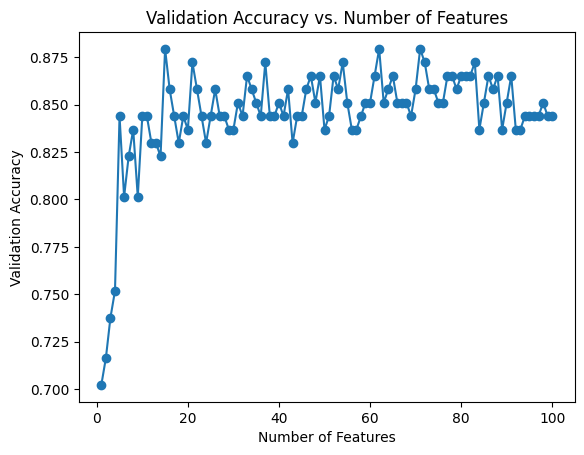

Optimal number of features: 15


In [62]:
for i in range(1,21):
    print(i)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    xgb_model = xgboost(X_train, y_train, X_test, y_test)

    X_train_selected, X_test_selected = find_best_num_features(X_train, y_train, X_test, y_test, xgb_model)
    X_train_selected
    SHAP_Feature_selection.append(X_train_selected)

## Selection

In [63]:

from collections import Counter
# Using list comprehension to flatten the list
features = [item for sublist in SHAP_Feature_selection for item in sublist]
# Count occurrences of each feature
feature_counts = Counter(features)

print(feature_counts)


Counter({'BertzCT': 20, 'HallKierAlpha': 20, 'MinAbsEStateIndex': 20, 'PEOE_VSA1': 19, 'SlogP_VSA2': 18, 'PEOE_VSA6': 17, 'PEOE_VSA9': 17, 'MinEStateIndex': 17, 'Chi4v': 17, 'FpDensityMorgan1': 16, 'EState_VSA4': 16, 'FpDensityMorgan3': 15, 'EState_VSA2': 15, 'VSA_EState4': 15, 'VSA_EState8': 14, 'VSA_EState6': 14, 'VSA_EState7': 14, 'SlogP_VSA4': 14, 'Chi0v': 13, 'Kappa1': 13, 'PEOE_VSA14': 13, 'SMR_VSA10': 13, 'SPS': 13, 'MaxAbsPartialCharge': 12, 'HeavyAtomMolWt': 12, 'BalabanJ': 12, 'EState_VSA3': 12, 'VSA_EState5': 12, 'EState_VSA8': 12, 'MaxAbsEStateIndex': 12, 'MinAbsPartialCharge': 11, 'AvgIpc': 11, 'TPSA': 11, 'Chi2v': 11, 'PEOE_VSA7': 11, 'MinPartialCharge': 11, 'SMR_VSA5': 11, 'PEOE_VSA11': 11, 'Chi1v': 10, 'FractionCSP3': 10, 'Chi4n': 10, 'Kappa3': 10, 'qed': 10, 'Chi2n': 10, 'Chi1n': 9, 'MaxPartialCharge': 9, 'MaxEStateIndex': 9, 'SMR_VSA4': 9, 'SlogP_VSA10': 9, 'Ipc': 9, 'EState_VSA9': 9, 'VSA_EState3': 9, 'EState_VSA5': 9, 'SlogP_VSA3': 9, 'FpDensityMorgan2': 9, 'Kappa2'

In [68]:
threshold = 16  # Minimum number of votes required
selected_features = [feature for feature, count in feature_counts.items() if count >= threshold]

print(len(selected_features))

11


## Save Selected Features

In [69]:
selected_features

['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'FpDensityMorgan1',
 'EState_VSA4',
 'PEOE_VSA6',
 'MinAbsEStateIndex',
 'PEOE_VSA9',
 'MinEStateIndex',
 'SlogP_VSA2',
 'Chi4v']

In [110]:
#selected_features = list(X_train_selected.columns)
selected_features.append("Irritation")

# Convert to DataFrame
df_selected = df[selected_features]

# Export to Excel
df_selected.to_excel("Features/Rabbit_B_SHAP_DT2.xlsx", index=False)